In [26]:
import sys
sys.path.append("..")
import pandas as pd
import util_functions as uf
import altair as alt
import json
import requests
import numpy as np
from datetime import date

In [27]:
alt.renderers.enable('notebook')
alt.themes.enable('opaque')

ThemeRegistry.enable('opaque')

In [30]:
def daily_totals(con):
    # Query Dockless Start by ANC and Overlaps
    return pd.read_sql("""/* Spin, Jump and Mobike*/
                        (SELECT
                        created::date as date, 
                        provider, 
                        COUNT(DISTINCT bike_id) as "Bikes on the Street"
                        FROM bike_locations
                        WHERE provider not in ('ofo','limebike')                    
                        GROUP BY provider, created::date)
                        /* Ofo*/
                        UNION
                        (SELECT 
                        created as date, 
                        'ofo' as provider, 
                        max("count") as "Bikes on the Street"
                        from 
                        (select 
                        count(bike_id), 
                        bike_id, 
                        created::date 
                        from bike_locations
                         WHERE 
                         provider='ofo'
                        group by bike_id, created::date) as counts_per_batch
                        group by created
                        )
                        /*Lime Bikes*/
                        UNION
                        (SELECT DISTINCT
                        loc.date as date,
                        'lime' as provider,
                        /* Known Bike Count / Known Lime Count * Unknown Lime Count*/
                        (COUNT(distinct bike.bike_id) / (COUNT(distinct bike.bike_id) + COUNT(distinct scooter.bike_id)):: float)  * 
                        (COUNT(distinct lime.bike_id)-COUNT(distinct bike.bike_id)-COUNT(distinct scooter.bike_id)) :: int
                        +  COUNT(distinct bike.bike_id) :: int as "Bikes on the Street"
                        FROM
                        (select distinct
                        created::date as date, 
                        bike_id 
                        from bike_locations
                        where provider='limebike') as loc
                        LEFT JOIN
                        ((SELECT DISTINCT
                        bike_id
                        FROM
                        (SELECT DISTINCT 
                        bike_id,
                        min(created::date) as start_date
                        FROM bike_locations
                        WHERE
                        provider='limebike'
                        group by bike_id) as lime_starts
                        /*any limes that started before 3/10 assumed to be bikes*/
                        WHERE start_date < '2018-03-10')
                        UNION
                        (SELECT DISTINCT 
                        bike_id
                        FROM bike_locations
                        WHERE
                        provider='limebike' AND
                        raw->'attributes'->>'vehicle_type'='bike'
                        group by 1)) as bike
                        on loc.bike_id = bike.bike_id 
                        LEFT JOIN
                        (SELECT DISTINCT 
                        bike_id
                        FROM bike_locations
                        WHERE
                        provider='limebike' AND
                        raw->'attributes'->>'vehicle_type'='scooter'
                        group by 1) as scooter
                        on loc.bike_id = scooter.bike_id 
                        LEFT JOIN
                        (SELECT DISTINCT 
                        bike_id
                        FROM bike_locations
                        WHERE
                        provider='limebike'
                        group by 1) as lime
                        on loc.bike_id = lime.bike_id 
                        group by 1
                        order by 1)
                        order by provider, date;
                """, con=con)

In [31]:
uf.set_env_path()
conn, cur = uf.local_connect()
# Return Dataframe bike per day
df = daily_totals(con=conn)

df.to_csv("daily_bike_count.csv")

## Format the Dataframe

In [32]:
# Convert date fields to datetime
df['date'] = pd.to_datetime(df['date'])

# Smooth out days with outliers due to API issues
df['Bikes on the Street'] = np.where((df['provider'] == 'ofo') & 
                                     (df['Bikes on the Street'] < 20) & 
                                     (df['date'] <= '2018-04-10'), 400, df['Bikes on the Street'])
df['Bikes on the Street'] = np.where((df['Bikes on the Street'] > 500) & 
                                     (df['date'] <= '2018-04-10'), 450, df['Bikes on the Street'])

## Spin Bikes Disappear on 8/17

In [11]:
spin_df = df[df['provider'] == 'spin']
# Pad out the rest of the days in the Dataframe
spin_padding_df = pd.DataFrame(pd.date_range(start=spin_df['date'].max(), end=df['date'].max()), columns=['date'])
spin_padding_df['Bikes on the Street'] = 0
spin_padding_df['provider'] = 'spin'

spin_df = pd.concat([spin_df, spin_padding_df], axis=0)
spin_df.tail()

,Bikes on the Street,bike_count,date,provider
119,0,NaN,2018-09-10,spin
120,0,NaN,2018-09-11,spin
121,0,NaN,2018-09-12,spin
122,0,NaN,2018-09-13,spin
123,0,NaN,2018-09-14,spin


In [17]:
# Merge on spin exit date
spin_dates = [date(2018,4,27),
              date(2018,8,17)]
spin_events = [' DDOT extends pilot to Aug',
               ' Spin exits DC']

# Define Dataframe of Mobike Events
spin_events_df = pd.DataFrame({'date': spin_dates, 'spin_event': spin_events})
spin_events_df['provider'] = 'spin'
spin_events_df['date'] = pd.to_datetime(spin_events_df['date'])

# Merge on Dataframe of Mobike Events
spin_df = spin_df.merge(spin_events_df, on=['date', 'provider'], how='left')


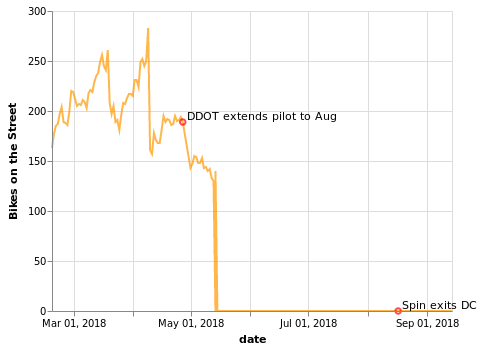

In [20]:
line_chart = alt.Chart(spin_df).mark_line(opacity=0.7).encode(
             alt.X('date'),
             alt.Y('Bikes on the Street'),
             alt.Color('provider',
                       legend=None,
                      scale=alt.Scale(range=['#ff9900']))
             )

# spin points
spin_points = alt.Chart(spin_df[~spin_df['spin_event'].isnull()]
             ).mark_point(color='red'
                
             ).encode(
             alt.X('date'),
             alt.Y('Bikes on the Street')
)

# Spin Annotated points
spin_text = spin_points.mark_text(
                  align='left',
                  baseline='bottom',
        ).encode(
            text='spin_event',
        )


spin_plot = line_chart + spin_points + spin_text

spin_plot.save('spin.html')
spin_plot

### Plot Notes

* Spin has about 50 bikes still showing on their API.  Most are in a warehouse in Ivy City, while there are a handle that seem to be out in the wild
* Reached out to Transit app to see if I can fill in the gap here
* Spin averaging about 200 bikes for the time period we have, but start to creep below 150 right before data goes missing on my end

## Ofo and Mobike Only (Chinese Companies that largely left US Market)

In [21]:
chinese_df = df[df['provider'].isin(['ofo', 'mobike'])]

# Pivot Dataframe so each provider has same dates, Fill in zeros for mobike
chinese_df = chinese_df.pivot(index='date', columns='provider', values='Bikes on the Street')
chinese_df['mobike'].fillna(0, inplace=True)
chinese_df['ofo'].fillna(400, inplace=True)
chinese_df.reset_index(inplace=True)

# Melt Dataframe for plotting in Altair
chinese_df =  pd.melt(chinese_df, id_vars=['date'],
                         value_vars=['mobike', 'ofo'],
                         value_name = 'Bikes on the Street',
                      
                         var_name = 'provider',
                         )

### Add Timeline Events to Dataframe to Annotate Plot

* 4/27/2018 - DDOT extends pilot to Aug
* 7/20/2018 - Mobike app goes dark
* 7/24/2018 - Ofo announces DC exit
* 7/25/2018 - Mobike announces DC exit
* 7/30/2018 - Ofo DC exit


In [22]:
mobike_dates = [date(2018,4,27), 
                date(2018,7,20), 
                date(2018,7,25)]

mobike_events = ['DDOT extends pilot  ', 
                  'Mobike app goes dark   ', 
                  'Mobike annouces exit ']

ofo_dates = [date(2018,7,24), 
             date(2018,7,30)]
ofo_events = ['  Ofo annouces exit', 
              '  Ofo exits']

# Define Dataframe of Mobike Events
mobike_events_df = pd.DataFrame({'date': mobike_dates, 'mobike_event': mobike_events})
mobike_events_df['provider'] = 'mobike'
mobike_events_df['date'] = pd.to_datetime(mobike_events_df['date'])

# Merge on Dataframe of Mobike Events
chinese_df = chinese_df.merge(mobike_events_df, on=['date', 'provider'], how='left')
chinese_df['mobike_event'] =  chinese_df['mobike_event'].fillna('')

# Define Dataframe of Ofo Events
ofo_events_df = pd.DataFrame({'date': ofo_dates, 'ofo_event': ofo_events})
ofo_events_df['provider'] = 'ofo'
ofo_events_df['date'] = pd.to_datetime(ofo_events_df['date'])

# Merge on Dataframe of Ofo Events
chinese_df = chinese_df.merge(ofo_events_df, on=['date', 'provider'], how='left')
chinese_df['ofo_event'] =  chinese_df['ofo_event'].fillna('')


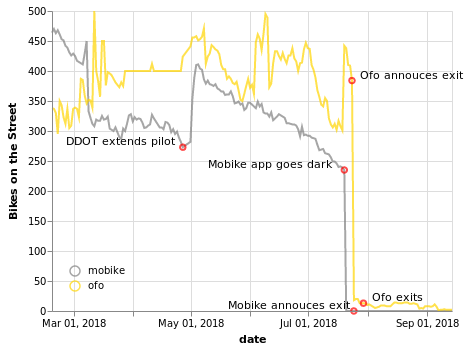

In [25]:
line_chart = alt.Chart(chinese_df).mark_line(opacity=0.7).encode(
             alt.X('date'),
             alt.Y('Bikes on the Street'),
             alt.Color('provider',
                       legend=alt.Legend(title=None, orient='bottom-left'),
                       scale=alt.Scale(range=['#808080','#ffd500']))
             )


# Mobike points
mobike_points = alt.Chart(chinese_df[chinese_df['mobike_event'] != '']
             ).mark_point(color='red'
                
             ).encode(
             alt.X('date'),
             alt.Y('Bikes on the Street')
)

# Mobike Annotated points
mobike_text = mobike_points.mark_text(
                  align='right',
                  baseline='bottom',
        ).encode(
            text='mobike_event',
        )

# Ofo points
ofo_points = alt.Chart(chinese_df[chinese_df['ofo_event'] != '']
             ).mark_point(color='red'
                
             ).encode(
             alt.X('date'),
             alt.Y('Bikes on the Street')
)

# Ofo Annotated points
ofo_text = ofo_points.mark_text(
                  align='left',
                  baseline='bottom',
        ).encode(
            text='ofo_event',
        )



chinese_plot = line_chart + mobike_points + mobike_text + ofo_points + ofo_text
chinese_plot.save('chinese.html')

chinese_plot

### Plot Notes


* Ofo and Mobike take different tactics for leaving the DC market.  
* Ofo maintains about 400 bikes on the street until 7/24 the day of they announce they are leaving the DC market.  You can see above that they even replenish their on street bikes several days before the annoucement, going from 300 to 450 bikes on the street. Once the annoucement is made, the number of Ofo bikes drops suddently from 400 to 18.
* While Mobike's exit annoucement may have seen just as suddet, by comparison, Mobike more gradually paired down it's fleet. Above, we can see a surge on Mobikes put on the street right after DDOT annouces the extension of the DoBi pilot through August on April 27, but from this point on Mobike doesn't replenish it's fleet, letting the total Mobikes on the street dip below 250 bikes as of July 20th when the Mobike app goes dark - 4 days before they annouce their exit from the DC market.


## Plotting All Operators (Jump Analysis)

In [40]:
# Merge on spin exit date
jump_dates = [date(2018,8,30)]
jump_events = ['DDOT extends pilot through Dec ']

# Define Dataframe of Mobike Events
jump_events_df = pd.DataFrame({'date': jump_dates, 'jump_event': jump_events})
jump_events_df['provider'] = 'JUMP'
jump_events_df['date'] = pd.to_datetime(jump_events_df['date'])

# Merge on Dataframe of Mobike Events
jump_df = df.merge(jump_events_df, on=['date', 'provider'], how='left')


jump_df.to_csv('jump_df.csv')

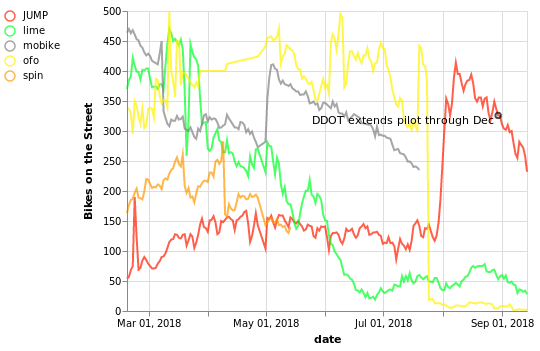

In [75]:
line_chart = alt.Chart(jump_df).mark_line(opacity=0.7).encode(
                 alt.X('date'),
                 alt.Y('Bikes on the Street'),
                 alt.Color('provider',
                            legend=alt.Legend(title=None, orient='left'), 
                 scale=alt.Scale(range=['#ff1d00', '#00ff26', '#808080', '#fff200', '#ff9900']))
            )

# jump points
jump_points = alt.Chart(jump_df[~jump_df['jump_event'].isnull()]
             ).mark_point(color='black'
                
             ).encode(
             alt.X('date'),
             alt.Y('Bikes on the Street')
)

# Jump Annotated points
jump_text = jump_points.mark_text(
                  align='right',
                  baseline='top',
        ).encode(
            text='jump_event',
        )

all_providers_chart = line_chart  + jump_points + jump_text
all_providers_chart.save('all_providers.html')

all_providers_chart

In [60]:
def jump_v_lime(con):
    # Query Jump and Lime Trips
    return pd.read_sql("""/* Jump Bikes*/
                             (SELECT
                            created::date as date, 
                            'jump bikes' as provider, 
                            COUNT(DISTINCT bike_id) as "Vehicles on the Street"
                            FROM bike_locations
                            WHERE provider in ('JUMP')                    
                            GROUP BY created::date)
                            /* Lime*/
                            UNION
                            (SELECT DISTINCT
                            loc.date,
                            'lime scooters' as provider,
                            /* Known Scooter Count / Known Lime Count * Unknown Lime Count*/
                            (COUNT(distinct scooter.bike_id) / (COUNT(distinct bike.bike_id) + COUNT(distinct scooter.bike_id)):: float)  * 
                            (COUNT(distinct lime.bike_id)-COUNT(distinct bike.bike_id)-COUNT(distinct scooter.bike_id)) :: int
                            +  COUNT(distinct scooter.bike_id) :: int as "Vehicles on the Street"
                            FROM
                            (select distinct
                            created::date as date, 
                            bike_id 
                            from bike_locations
                            where provider='limebike') as loc
                            LEFT JOIN
                            ((SELECT DISTINCT
                            bike_id
                            FROM
                            (SELECT DISTINCT 
                            bike_id,
                            min(created::date) as start_date
                            FROM bike_locations
                            WHERE
                            provider='limebike'
                            group by bike_id) as lime_starts
                            /*any limes that started before 3/10 assumed to be bikes*/
                            WHERE start_date < '2018-03-10')
                            UNION
                            (SELECT DISTINCT 
                            bike_id
                            FROM bike_locations
                            WHERE
                            provider='limebike' AND
                            raw->'attributes'->>'vehicle_type'='bike'
                            group by 1)) as bike
                            on loc.bike_id = bike.bike_id 
                            LEFT JOIN
                            (SELECT DISTINCT 
                            bike_id
                            FROM bike_locations
                            WHERE
                            provider='limebike' AND
                            raw->'attributes'->>'vehicle_type'='scooter'
                            group by 1) as scooter
                            on loc.bike_id = scooter.bike_id 
                            LEFT JOIN
                            (SELECT DISTINCT 
                            bike_id
                            FROM bike_locations
                            WHERE
                            provider='limebike'
                            group by 1) as lime
                            on loc.bike_id = lime.bike_id 
                            group by 1
                            order by 1)
                            order by provider, date;
                            """, con=con)

In [61]:
# Return Dataframe Lime Scooters vs Jump Bikes per day
jump_lime_df = jump_v_lime(con=conn)

jump_lime_df.to_csv("jump_lime_df.csv")

In [64]:
jump_lime_df['date'] = pd.to_datetime(jump_lime_df['date'])

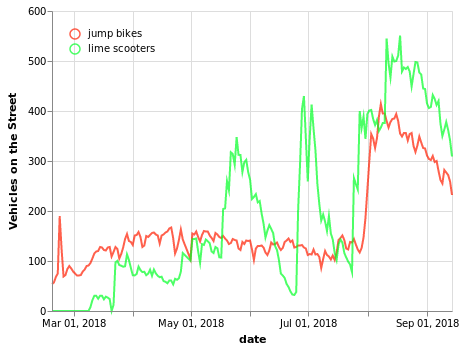

In [73]:
jump_lime_line_chart = alt.Chart(jump_lime_df).mark_line(opacity=0.7).encode(
                 alt.X('date'),
                 alt.Y('Vehicles on the Street'),
                 alt.Color('provider',
                            legend=alt.Legend(title=None, orient='top-left'), 
                 scale=alt.Scale(range=['#ff1d00', '#00ff26']))
            )

jump_lime_line_chart.save('jump_lime.html')

jump_lime_line_chart


### Jump Notes

* Jump capitalizes on Ofo and Mobike departing the DC market by increasing it's fleet size from 126 on July 29th to 414 on August 8th.
* It seems as if maintaing such a larger fleet is starting to take it's toll on Jump, as the daily number of bikes on the street has been in steady decline since August 8th (similar to Lime decline once started all scooters)


## Conclusion Notes

* All stakeholders involved had some impact on dockless bike exit
 * _Chinese Dockless Operators_ - Opportunity costs, strategitic exited US markets, Mobike stayed in markets with less established docked bikeshare systems, citing Charlotte
 * _Dockless Operators transition to scooters_ - Both Spin and Lime found that scooters cited popularity of scooters for either replacing their entire fleet or exiting the market completely to retool their business model
 * _DDOT extending the pilot twice_ - What once was an 9 month pilot has now become a 16 month pilot due to two extends by DDOT either a few days before or on the day the pilot was set to end.  Operators cited this moving  goal post and restrictive rules as reasons why they either left the market or converted to scooters.  The most interesting move that DDOT made was attached a new rule to the most recent pilot extension requiring  all dockless bikes have the ability to lock to a fixed structure like a bike rack.  While this rule may have been viewed as unnecessary, since Jump (which adheres to this rule) was the only dockless operator left when the rule was made, I see this rule as foreshadowing what rules and operators DDOT favors coming out of the pilot
 
 